Electric energy consumption prediction using Machine Learning
Household Electricity consumption
https://www.kaggle.com/datasets/uciml/electric-power-consumption-data-set?resource=download

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing
df = pd.read_csv('Resources/data/household_power_consumption.txt', sep=';', 
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')

df.shape

(2075259, 7)

In [4]:
df.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

Handle null values, replace with mean values

In [5]:
df = df.fillna(df.mean())

Database method - Postgres
Create Database
Create Staging Table
Load Data from file

In [ ]:
CREATE TABLE household_power_consumption
 
Global_active_power     numeric ,
Global_reactive_power   numeric ,
Voltage                numeric ,  
Global_intensity   numeric ,
Sub_metering_2      numeric ,    
Sub_metering_3      numeric     )    ;
    

In [ ]:
COPY household_power_consumption
FROM 'Resources/data/household_power_consumption.txt' HEADER CSV DELIMITER ';';

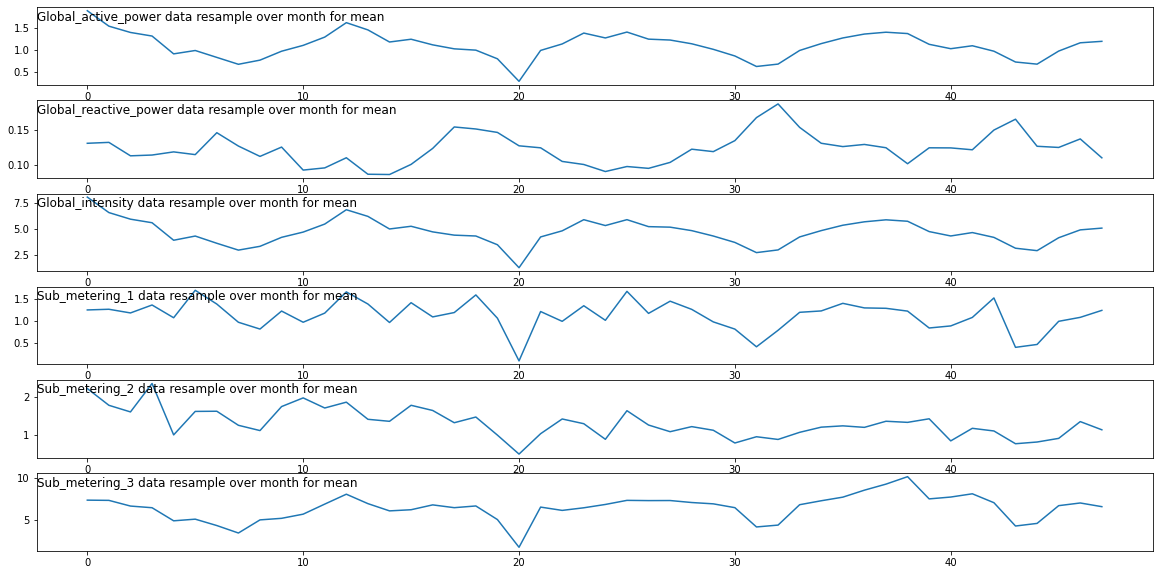

In [6]:
import matplotlib.pyplot as plt

i = 1
cols=[0, 1, 3, 4, 5, 6]
plt.figure(figsize=(20, 10))
for col in cols:
    plt.subplot(len(cols), 1, i)
    plt.plot(df.resample('M').mean().values[:, col])
    plt.title(df.columns[col] + ' data resample over month for mean', y=0.75, loc='left')
    i += 1
plt.show()

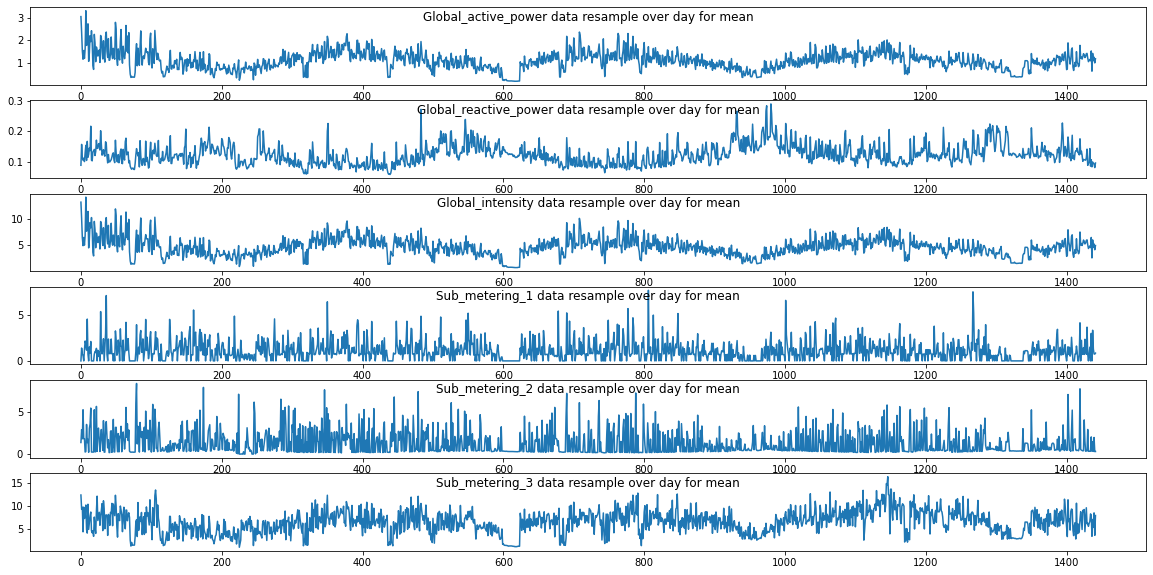

In [7]:
i = 1
cols=[0, 1, 3, 4, 5, 6]
plt.figure(figsize=(20, 10))
for col in cols:
    plt.subplot(len(cols), 1, i)
    plt.plot(df.resample('D').mean().values[:, col])
    plt.title(df.columns[col] + ' data resample over day for mean', y=0.75, loc='center')
    i += 1
plt.show()

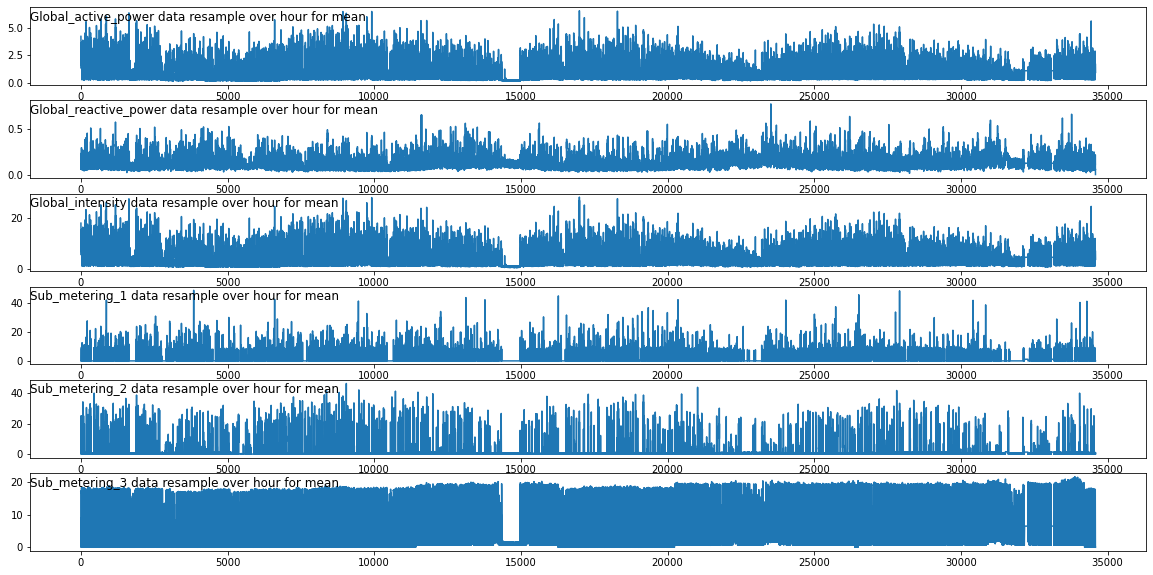

In [8]:
i = 1
cols=[0, 1, 3, 4, 5, 6]
plt.figure(figsize=(20, 10))
for col in cols:
    plt.subplot(len(cols), 1, i)
    plt.plot(df.resample('H').mean().values[:, col])
    plt.title(df.columns[col] + ' data resample over hour for mean', y=0.75, loc='left')
    i += 1
plt.show()

Observations:
Resampling by month, date or time is very important because it has a great interaction as expected (changing the periodicity of the system).
Therefore, if you process all the original data, the run time will be very expensive, but if you process data with large timescale samples (e.g., monthly), it will affect the predictability of the model.
From observation, we can see it is relatively reasonable to resample the data per hour.

Data is time series, use LSTM machinelearning

In [9]:
df = df[['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_2', 'Sub_metering_1','Sub_metering_3']]
       
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(-i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i==0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1)) for j in range(n_vars)]        
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        if dropnan:
            agg.dropna(inplace=True)
        return agg

In [10]:
df_resample = df.resample('h').mean() 
df_resample.shape

(34589, 7)

Prepare and process data

In [11]:
from sklearn.preprocessing import MinMaxScaler

values = df_resample.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
r = list(range(df_resample.shape[1]+1, 2*df_resample.shape[1]))
reframed.drop(reframed.columns[r], axis=1, inplace=True)
reframed.head()

# Data spliting into train and test data series. Only 4000 first data points are selected for traing purpose.
values = reframed.values
n_train_time = 4000
train = values[:n_train_time, :]
test = values[n_train_time:, :]
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))

Epoch 1/50
58/58 - 3s - loss: 0.0265 - val_loss: 0.0105 - 3s/epoch - 47ms/step
Epoch 2/50
58/58 - 1s - loss: 0.0153 - val_loss: 0.0102 - 956ms/epoch - 16ms/step
Epoch 3/50
58/58 - 1s - loss: 0.0142 - val_loss: 0.0101 - 902ms/epoch - 16ms/step
Epoch 4/50
58/58 - 1s - loss: 0.0135 - val_loss: 0.0098 - 907ms/epoch - 16ms/step
Epoch 5/50
58/58 - 1s - loss: 0.0130 - val_loss: 0.0097 - 629ms/epoch - 11ms/step
Epoch 6/50
58/58 - 1s - loss: 0.0126 - val_loss: 0.0096 - 624ms/epoch - 11ms/step
Epoch 7/50
58/58 - 1s - loss: 0.0123 - val_loss: 0.0094 - 604ms/epoch - 10ms/step
Epoch 8/50
58/58 - 1s - loss: 0.0122 - val_loss: 0.0094 - 615ms/epoch - 11ms/step
Epoch 9/50
58/58 - 1s - loss: 0.0121 - val_loss: 0.0094 - 590ms/epoch - 10ms/step
Epoch 10/50
58/58 - 1s - loss: 0.0119 - val_loss: 0.0093 - 614ms/epoch - 11ms/step
Epoch 11/50
58/58 - 1s - loss: 0.0118 - val_loss: 0.0093 - 616ms/epoch - 11ms/step
Epoch 12/50
58/58 - 1s - loss: 0.0119 - val_loss: 0.0092 - 620ms/epoch - 11ms/step
Epoch 13/50
58/5

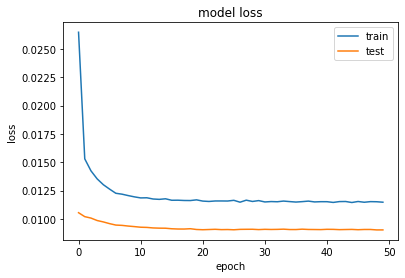

Test RMSE: 0.611


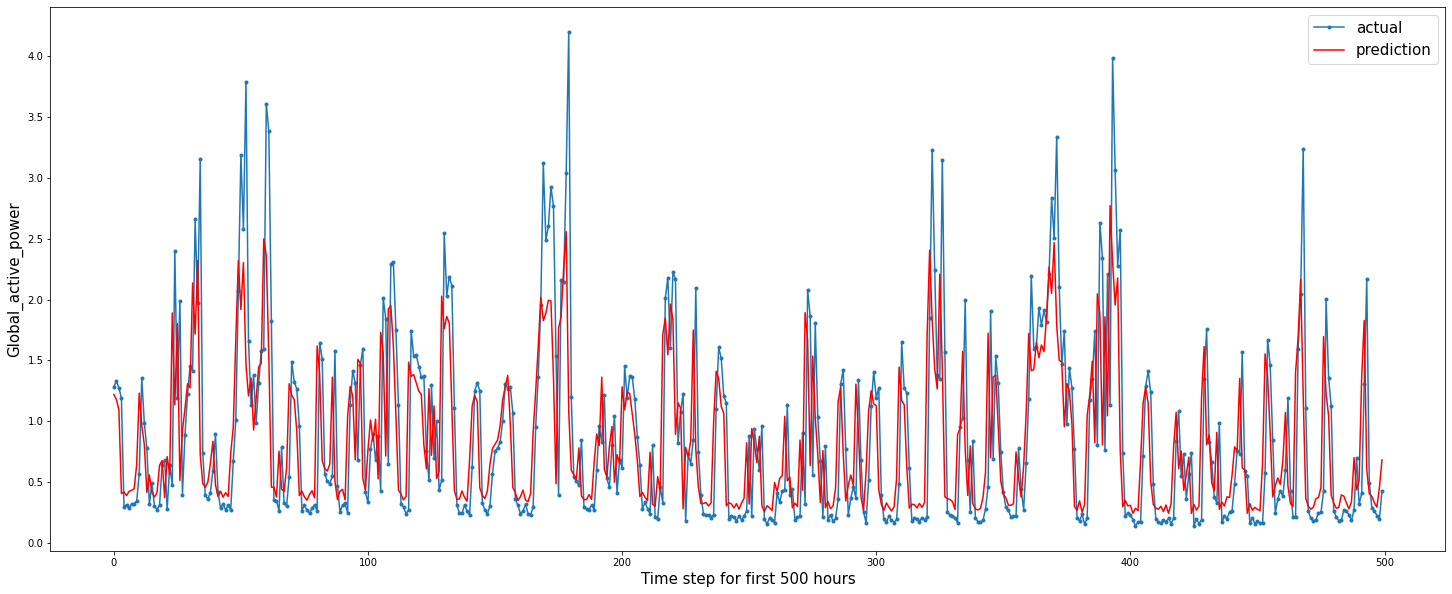

In [12]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from sklearn.metrics import mean_squared_error,r2_score
import matplotlib.pyplot as plt
import numpy as np

model = Sequential()
model.add(LSTM(100, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Network fitting
history = model.fit(train_x, train_y, epochs=50, batch_size=70, validation_data=(test_x, test_y), verbose=2, shuffle=False)

# Loss history plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

size = df_resample.shape[1]

# Prediction test
yhat = model.predict(test_x)
test_x = test_x.reshape((test_x.shape[0], size))

# invert scaling for prediction
inv_yhat = np.concatenate((yhat, test_x[:, 1-size:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_x[:, 1-size:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

aa=[x for x in range(500)]
plt.figure(figsize=(25,10)) 
plt.plot(aa, inv_y[:500], marker='.', label="actual")
plt.plot(aa, inv_yhat[:500], 'r', label="prediction")
plt.ylabel(df.columns[0], size=15)
plt.xlabel('Time step for first 500 hours', size=15)
plt.legend(fontsize=15)
plt.show()